In [1]:
import torch 
import torch.nn as nn 
import torch.nn.functional as f
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt 
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')


In [23]:
data = pd.read_csv('mnist_train.csv')
data = data.values
labels = data[:, 0]
data = data[:,1:]
data = torch.tensor(data).float()
labels = torch.tensor(labels)

print(labels.shape)
print(data.shape)

torch.Size([20000])
torch.Size([20000, 784])


In [33]:
train_data = data[np.where(labels != 7)]
train_labels = labels[np.where(labels != 7)]
test_data = data[np.where(labels == 7)]
test_labels = labels[np.where(labels == 7)]

In [13]:
train_data.shape

(17930, 784)

In [25]:
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels) 

# dataloaders 
train_loader = DataLoader(train_data, batch_size = 32)
test_loader = DataLoader(test_data, batch_size = len(test_data))

In [27]:
def createTheMNISTNet():

    class mnistNet(nn.Module):
        def __init__(self):
            super().__init__()
            

            # input layer 
            self.input = nn.Linear(784, 64)

            # hidden layers
            self.fc1 = nn.Linear(64,32)
            self.fc2 = nn.Linear(32,32)

            # output layer 
            self.output = nn.Linear(32, 10)

        def forward(self, X):
            
            X = f.relu(self.input(X))
            X = f.relu(self.fc1(X))
            X = f.relu(self.fc2(X))

            return self.output(X)
        
    # create the model instance 
    net = mnistNet()

    # loss function 
    lossfun = nn.CrossEntropyLoss()

    # optimizer 
    optimizer = torch.optim.SGD(net.parameters(), lr = .01)

    return net, lossfun, optimizer 



            
            

In [28]:
def function2trainTheModel():

    # number of epochs 
    numepochs = 100

    # create a new model 
    net, lossfun, optimizer = createTheMNISTNet()

    # losses 
    losses = np.zeros(numepochs)
    trainAcc = []
    


    for epochi in range(numepochs):
        net.train()
        batchAcc = []
        batchLoss = []

        for X, y in train_loader:

            yHat = net(X)
            loss = lossfun(yHat, y)
            batchLoss.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # matches 
            matches = (torch.argmax(yHat, axis = 1) == y ).float()
            accuracypct = 100*torch.mean(matches)
            batchAcc.append(accuracypct)
        
        losses[epochi] = np.mean(batchLoss)
        trainAcc.append(np.mean(batchAcc))

    net.eval()
    X, y = next(iter(test_loader))
    with torch.inference_mode():
        yHat = net(X)
        

    return trainAcc, losses, yHat, net


In [36]:
trainAcc, losses, yHat, net = function2trainTheModel()

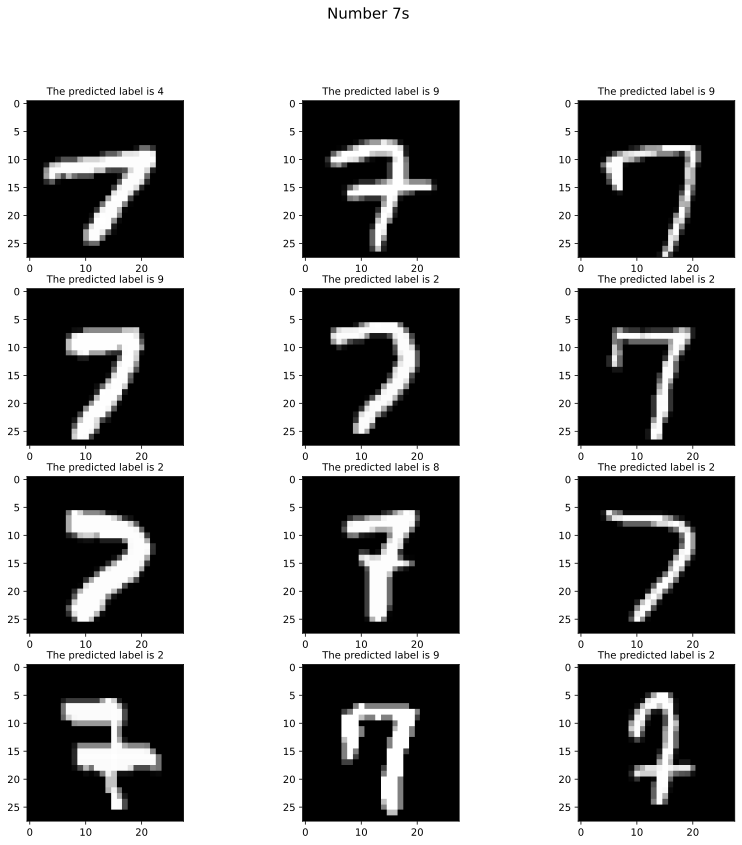

In [59]:
fig, axs = plt.subplots(4,3, figsize = (14,13))

for ax in axs.flatten():

    # random image to show from the test set 
    randimg2show = np.random.randint(0, len(test_data))

    img = np.reshape(test_data[randimg2show],(28,28))

    ax.imshow(img, cmap = "gray")
    ax.set_title(f"The predicted label is {torch.argmax(yHat[randimg2show])}", fontsize = 10)

plt.suptitle('Number 7s', fontsize = 15)

plt.show()

    


[0 1 2 3 4 5 6 8 9]


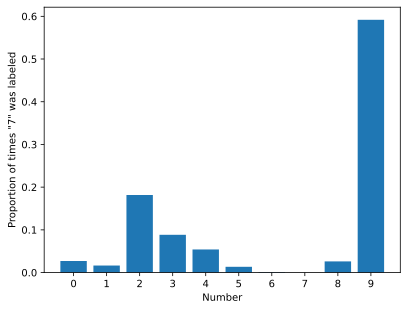

In [62]:
# which numbers are most likely to be confused with 7?
print( np.unique(torch.argmax(yHat, axis = 1)) )

probMistaken = np.zeros(10)

for i in range(10):
  probMistaken[i] = torch.mean((torch.argmax(yHat, axis = 1)==i).float())

plt.bar(range(10),probMistaken)
plt.xticks(range(10))
plt.xlabel('Number')
plt.ylabel('Proportion of times "7" was labeled')
plt.show()